In [1]:
# Basic Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator
%matplotlib inline


In [2]:
# For Train test split
from sklearn.model_selection import train_test_split

In [3]:
# For pre-processing of text
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout,GlobalAveragePooling1D,Flatten,SpatialDropout1D

In [5]:
df=pd.read_csv("C:\\Users\\Dipsan\\Desktop\\Spam message Detection\\spam.csv" , encoding='ISO-8859-1')
df=df[['v1','v2']]
df.rename(columns={'v1':'Category','v2':'Content'},inplace=True)

df.head()

,Category,Content
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
# Concatenate all strings into a single string
spam_text=[i for  i in df['Content']]
spam_text_final=''
for i in spam_text:
    spam_text_final=spam_text_final+str(i)
print(spam_text_final)

ham"Not from this campus. Are you in the library?The affidavit says  &lt;#&gt;  E Twiggs St, division g, courtroom  &lt;#&gt; , &lt;TIME&gt;  AM. I'll double check and text you again tomorrowHow will I creep on you now? ;_;Tell your friends what you plan to do on Valentines day @ &lt;URL&gt;If I get there before you after your ten billion calls and texts so help me godPurity of friendship between two is not about smiling after reading the forwarded message..Its about smiling just by seeing the name. Gud evng musthuI've told him that i've returned it. That should i re order it.House-Maid is the murderer, coz the man was murdered on  &lt;#&gt; th January.. As public holiday all govt.instituitions are closed,including post office..Depends on where u going lor.And smile for me right now as you go and the world will wonder what you are smiling about and think your crazy and keep away from you ... *grins*FreeMsg>FAV XMAS TONES!Reply REALLil fever:) now fine:)I think it's all still in my carC

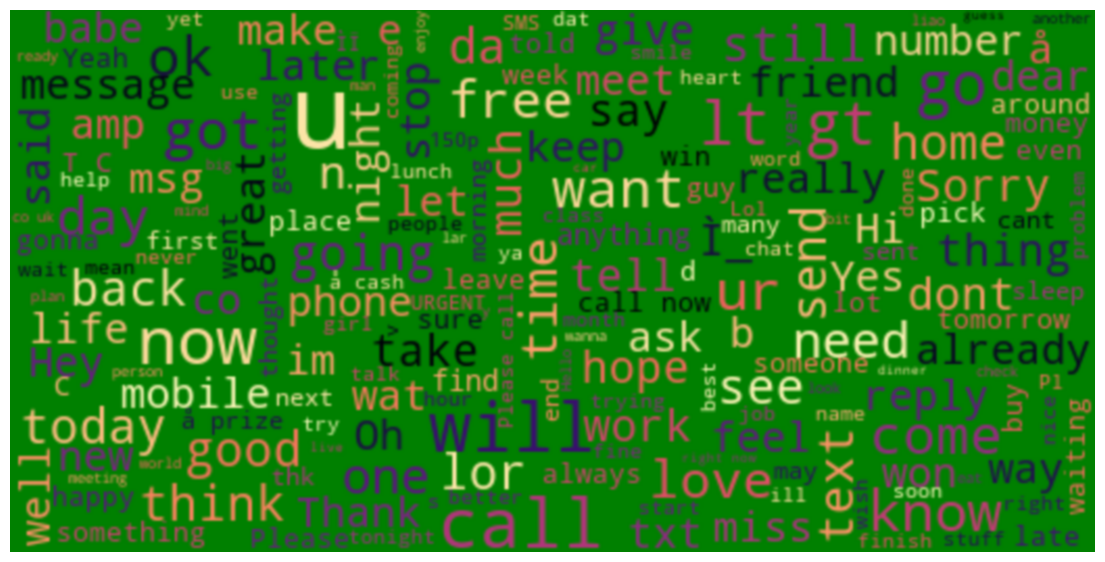

In [7]:
# Creating a word cloud
ham_msg_cloud=WordCloud(width=520,height=260,stopwords=STOPWORDS,max_font_size=50,background_color="green",colormap='magma').generate(spam_text_final)
plt.figure(figsize=(14,8))
plt.imshow(ham_msg_cloud,interpolation='bicubic')
plt.axis('off')
plt.show()

In [8]:
# Understand distribution of ham and spam messages
plt.figure(figsize=(8,6))
sns.countplot(df.label)


AttributeError: 'DataFrame' object has no attribute 'label'

<Figure size 800x600 with 0 Axes>

In [9]:
# Finding Length of each message
ham_category_df=df['Category']
ham_category_df=ham_category_df.sample(n=len(df['Content']),random_state=0)
spam_catgory_df=df['Content']

new_df=df.copy()
new_df['Content_Length']=new_df['Content'].apply(len)
new_df['Content_Type']=new_df['Category'].map({'ham':0,'spam':1})
content_label=new_df['Content_Type'].values
new_df.head()

,Category,Content,Content_Length,Content_Type
0,ham,"Go until jurong point, crazy.. Available only ...",111,0
1,ham,Ok lar... Joking wif u oni...,29,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,1
3,ham,U dun say so early hor... U c already then say...,49,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,0


In [16]:
# Define the parameters
max_len=50
trunc_type='post'
padding_type='post'
oov_token_1='OOV'# out of vocabulary token
vocab_size=500

In [21]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(new_df['Content'],content_label,test_size=0.2,random_state=0)

In [22]:

# Converting text into numerical representation - create a tokenizer and fit it on the training data
tokenizer=Tokenizer(num_words=vocab_size,
                   char_level=False,
                   oov_token=oov_token_1)
tokenizer.fit_on_texts(X_train)

In [24]:
# Get the word_index - calculate the total number of words in the vocabulary set
word_index=tokenizer.word_index
word_index=len(word_index)
word_index

7825

In [28]:
# converting the text data into numerical sequences & padding for same length
training_sequences=tokenizer.texts_to_sequences(X_train)
training_padded=pad_sequences(training_sequences,
                             maxlen=max_len,
                             padding=padding_type,
                             truncating=trunc_type)

testing_sequences=tokenizer.texts_to_sequences(X_test)
testing_padded=pad_sequences(testing_sequences,
                            maxlen=max_len,
                            padding=padding_type,
                            truncating=trunc_type)

In [37]:

# Model building and Dense Model Architecture
vocab_size=400
embedding_dim=12
drop_value=0.2
n_dense=5

model_rnn=Sequential()
model_rnn.add(Embedding(vocab_size,
                       embedding_dim,
                       input_length=max_len))
model_rnn.add(GlobalAveragePooling1D())
model_rnn.add(Dense(24,activation='relu'))
model_rnn.add(Dropout(drop_value))
model_rnn.add(Dense(1,activation='sigmoid'))
model_rnn.summary()



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 12)            4800      
                                                                 
 global_average_pooling1d_6  (None, 12)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_8 (Dense)             (None, 24)                312       
                                                                 
 dropout_4 (Dropout)         (None, 24)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 25        
                                                                 
Total params: 5137 (20.07 KB)
Trainable params: 5137 (20.07 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [38]:
model_rnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'
                                                                      ])

In [42]:
num_epochs=50
early_stop=EarlyStopping(monitor='val_loss',patience=3)
history=model_rnn.fit(training_padded,
                     y_train,
                     epochs=num_epochs,
                     validation_data=(testing_padded,y_test),
                     callbacks=[early_stop],
                     verbose=2)

Epoch 1/50


InvalidArgumentError: Graph execution error:

Detected at node sequential_6/embedding_6/embedding_lookup defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 736, in start

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dipsan\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dipsan\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dipsan\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code

  File "C:\Users\Dipsan\AppData\Local\Temp\ipykernel_150312\1279328011.py", line 3, in <module>

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1807, in fit

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 590, in __call__

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\keras\src\engine\sequential.py", line 398, in call

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\keras\src\engine\functional.py", line 515, in call

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py", line 272, in call

indices[1,12] = 470 is not in [0, 400)
	 [[{{node sequential_6/embedding_6/embedding_lookup}}]] [Op:__inference_train_function_1536]

In [43]:
model_rnn.evaluate(testing_padded,y_test)

InvalidArgumentError: Graph execution error:

Detected at node sequential_6/embedding_6/embedding_lookup defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 736, in start

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dipsan\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dipsan\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dipsan\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code

  File "C:\Users\Dipsan\AppData\Local\Temp\ipykernel_150312\1595369821.py", line 1, in <module>

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2296, in evaluate

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 4108, in run_step

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2066, in test_function

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2049, in step_function

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2037, in run_step

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1917, in test_step

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 590, in __call__

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\keras\src\engine\sequential.py", line 398, in call

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\keras\src\engine\functional.py", line 515, in call

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\Dipsan\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py", line 272, in call

indices[0,0] = 435 is not in [0, 400)
	 [[{{node sequential_6/embedding_6/embedding_lookup}}]] [Op:__inference_test_function_1786]

In [46]:
train_dense_results=model_rnn.evaluate(training_padded,np.asarray(y_train),verbose=2,batch_size=256)
test_dense_results=model_rnn.evaluate(testing_padded,np.asarray(y_test,verbose=2,batchs_size=256)
print('train accuracy':{train_dense_results})
print('Test accuracy':{test_dense_results})

SyntaxError: '(' was never closed (118726538.py, line 2)

In [47]:
n_lstm = 128
drop_lstm = 0.2
Model_lstm = Sequential()
model_lstm .add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model_lstm .add(SpatialDropout1D(drop_lstm))
model_lstm .add(LSTM(n_lstm, return_sequences=False))
model_lstm .add(Dropout(drop_lstm))
model_lstm .add(Dense(1, activation='sigmoid'))

model_lstm.summary()

model_lstm .compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])

num_epochs = 10
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model_lstm .fit(training_padded,
                     y_train,
                     epochs=num_epochs, 
                     validation_data=(testing_padded, y_test),
                     callbacks =[early_stop],
                     verbose=2)

model_lstm .evaluate(testing_padded, y_test)

train_dense_results = model_lstm .evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_dense_results = model_lstm .evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)
print('Train accuracy: {train_dense_results')
print(‘Test accuracy: {test_dense_results')

SyntaxError: invalid character '‘' (U+2018) (2988568386.py, line 30)